In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


In [2]:
parent_dir = "/pool001/vianajr/cluster_ages_1/results/single_case/"

case_1_dir = parent_dir + "single_case_5im_remextremes_no_augment_no_blackout_inner_normby_five-images/R_6/"
case_2_dir = parent_dir + "single_case_5im_remextremes_no_augment_no_blackout_outer_normby_five-images/R_6/"


In [3]:
dir_results_model_1 = case_1_dir + "model_0/"
dir_results_model_2 = case_2_dir + "model_0/"


In [4]:

# Define the custom metric function
def custom_median_absolute_error(dnrm_y_pred, dnrm_y_true):
    abs_diff = np.abs(dnrm_y_true - dnrm_y_pred)
    median_abs_diff = np.median(abs_diff)
    return 1.49 * median_abs_diff

# Load model 1 predictions and truths
with open(dir_results_model_1 + 'preds_and_trues.pkl', 'rb') as f:
    model_1_data = pickle.load(f)

# Load model 2 predictions and truths
with open(dir_results_model_2 + 'preds_and_trues.pkl', 'rb') as f:
    model_2_data = pickle.load(f)

# Extract the relevant data
use_Y_tr_1, use_Y_vl_1, use_Y_ts_1 = model_1_data['use_Y_tr'], model_1_data['use_Y_vl'], model_1_data['use_Y_ts']
use_Y_tr_2, use_Y_vl_2, use_Y_ts_2 = model_2_data['use_Y_tr'], model_2_data['use_Y_vl'], model_2_data['use_Y_ts']


In [5]:

# Check if they match
if np.array_equal(use_Y_tr_1, use_Y_tr_2) and np.array_equal(use_Y_vl_1, use_Y_vl_2) and np.array_equal(use_Y_ts_1, use_Y_ts_2):
    print("use_Y_tr, use_Y_vl, and use_Y_ts match between the two models.")
else:
    raise ValueError("Mismatch detected in use_Y_tr, use_Y_vl, or use_Y_ts!")


use_Y_tr, use_Y_vl, and use_Y_ts match between the two models.


In [6]:

# Extract predictions
dnrm_Y_tr_pred_1 = model_1_data['dnrm_Y_tr_pred']
dnrm_Y_vl_pred_1 = model_1_data['dnrm_Y_vl_pred']
dnrm_Y_ts_pred_1 = model_1_data['dnrm_Y_ts_pred']

dnrm_Y_tr_pred_2 = model_2_data['dnrm_Y_tr_pred']
dnrm_Y_vl_pred_2 = model_2_data['dnrm_Y_vl_pred']
dnrm_Y_ts_pred_2 = model_2_data['dnrm_Y_ts_pred']

# Define target variables (assumed same in both models)
use_Y_tr = use_Y_tr_1
use_Y_vl = use_Y_vl_1
use_Y_ts = use_Y_ts_1

# Train the linear regression model
X_tr = np.column_stack((dnrm_Y_tr_pred_1, dnrm_Y_tr_pred_2))
X_vl = np.column_stack((dnrm_Y_vl_pred_1, dnrm_Y_vl_pred_2))
X_ts = np.column_stack((dnrm_Y_ts_pred_1, dnrm_Y_ts_pred_2))

# Train:
reg_model = LinearRegression().fit(X_tr, use_Y_tr)

# Generate predictions
dnrm_Y_tr_pred_3 = reg_model.predict(X_tr)
dnrm_Y_vl_pred_3 = reg_model.predict(X_vl)
dnrm_Y_ts_pred_3 = reg_model.predict(X_ts)


In [7]:
X_tr

array([[7.772606 , 6.9320564],
       [6.8929043, 6.7229185],
       [7.965407 , 8.486246 ],
       ...,
       [7.358967 , 8.816067 ],
       [8.089143 , 7.079932 ],
       [8.481733 , 8.821631 ]], dtype=float32)

In [8]:
w_1 = 0.1
w_2 = 1 - w_1

w_1 = 0.10
w_2 = 0.90
b = 0 #-0.8404803

In [9]:
dnrm_Y_tr_pred_4 = w_1*dnrm_Y_tr_pred_1 + w_2*dnrm_Y_tr_pred_2 +b
dnrm_Y_vl_pred_4 = w_1*dnrm_Y_vl_pred_1 + w_2*dnrm_Y_vl_pred_2 +b
dnrm_Y_ts_pred_4 = w_1*dnrm_Y_ts_pred_1 + w_2*dnrm_Y_ts_pred_2 +b

In [10]:
print("Coefficients:", reg_model.coef_)      # Expected: [2.]
print("Intercept:", reg_model.intercept_)    # Expected: ~0

Coefficients: [0.1923067  0.92529863]
Intercept: -0.8404803


In [11]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-03-18 22:42:13.177336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 22:42:13.177439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 22:42:13.178804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 22:42:13.190648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Define a simple neural network
model = keras.Sequential([ 
    keras.layers.Dense(1024, input_shape=(2,)),
    keras.layers.Dense(32, ), 
    keras.layers.Dense(1) 
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

# Train the model
history = model.fit(X_tr, use_Y_tr, epochs=20, verbose=1,
                   validation_data=(X_vl, use_Y_vl)
                   ) 

Epoch 1/20
190/190 [==============================] - 2s 4ms/step - loss: 29.8985 - val_loss: 6.8594
Epoch 2/20
190/190 [==============================] - 1s 3ms/step - loss: 2.1289 - val_loss: 0.5089
Epoch 3/20
190/190 [==============================] - 1s 4ms/step - loss: 0.3305 - val_loss: 0.3797
Epoch 4/20
190/190 [==============================] - 1s 5ms/step - loss: 0.3034 - val_loss: 0.3741
Epoch 5/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2994 - val_loss: 0.3680
Epoch 6/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2952 - val_loss: 0.3614
Epoch 7/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2906 - val_loss: 0.3542
Epoch 8/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2856 - val_loss: 0.3467
Epoch 9/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2805 - val_loss: 0.3390
Epoch 10/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2751 - val_loss: 0.330

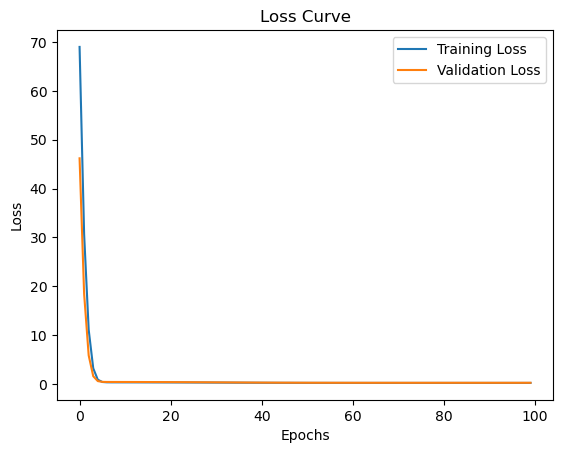

In [23]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [14]:
# Generate predictions
dnrm_Y_tr_pred_5 = model.predict(X_tr)
dnrm_Y_vl_pred_5 = model.predict(X_vl)
dnrm_Y_ts_pred_5 = model.predict(X_ts)

41/41 [==============================] - 0s 1ms/step


In [21]:
print("Training:")
print(f"  Model 1: {custom_median_absolute_error(dnrm_Y_tr_pred_1, use_Y_tr):.4f}")
print(f"  Model 2: {custom_median_absolute_error(dnrm_Y_tr_pred_2, use_Y_tr):.4f}")
print(f"  Linear Model: {custom_median_absolute_error(dnrm_Y_tr_pred_3, use_Y_tr):.4f}")
print(f"  Custom Model: {custom_median_absolute_error(dnrm_Y_tr_pred_4, use_Y_tr):.4f}")
print(f"  NN Model: {custom_median_absolute_error(dnrm_Y_tr_pred_5, use_Y_tr):.4f}")

print("\nValidation:")
print(f"  Model 1: {custom_median_absolute_error(dnrm_Y_vl_pred_1, use_Y_vl):.4f}")
print(f"  Model 2: {custom_median_absolute_error(dnrm_Y_vl_pred_2, use_Y_vl):.4f}")
print(f"  Linear Model: {custom_median_absolute_error(dnrm_Y_vl_pred_3, use_Y_vl):.4f}")
print(f"  Custom Model: {custom_median_absolute_error(dnrm_Y_vl_pred_4, use_Y_vl):.4f}")
print(f"  NN Model: {custom_median_absolute_error(dnrm_Y_vl_pred_5, use_Y_vl):.4f}")

print("\nTesting:")
print(f"  Model 1: {custom_median_absolute_error(dnrm_Y_ts_pred_1, use_Y_ts):.4f}")
print(f"  Model 2: {custom_median_absolute_error(dnrm_Y_ts_pred_2, use_Y_ts):.4f}")
print(f"  Linear Model: {custom_median_absolute_error(dnrm_Y_ts_pred_3, use_Y_ts):.4f}")
print(f"  Custom Model: {custom_median_absolute_error(dnrm_Y_ts_pred_4, use_Y_ts):.4f}")
print(f"  NN Model: {custom_median_absolute_error(dnrm_Y_ts_pred_5, use_Y_ts):.4f}")


Training:
  Model 1: 0.6805
  Model 2: 0.3639
  Linear Model: 0.3447
  Custom Model: 0.3678
  NN Model: 1.3556

Validation:
  Model 1: 0.8097
  Model 2: 0.4009
  Linear Model: 0.3922
  Custom Model: 0.4132
  NN Model: 1.3169

Testing:
  Model 1: 0.8038
  Model 2: 0.3510
  Linear Model: 0.3562
  Custom Model: 0.3607
  NN Model: 1.3420
